## Download Data

In [3]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [5]:
!mkdir ~/.kaggle

!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes

Dataset URL: https://www.kaggle.com/datasets/ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes
License(s): CC0-1.0
 97% 129M/133M [00:01<00:00, 117MB/s]
100% 133M/133M [00:01<00:00, 108MB/s]


In [8]:
!unzip /content/mri-for-brain-tumor-with-bounding-boxes.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: Train/No Tumor/images/Tr-no_1015.jpg  
  inflating: Train/No Tumor/images/Tr-no_1016.jpg  
  inflating: Train/No Tumor/images/Tr-no_1019.jpg  
  inflating: Train/No Tumor/images/Tr-no_1020.jpg  
  inflating: Train/No Tumor/images/Tr-no_1022.jpg  
  inflating: Train/No Tumor/images/Tr-no_1025.jpg  
  inflating: Train/No Tumor/images/Tr-no_1031.jpg  
  inflating: Train/No Tumor/images/Tr-no_1032.jpg  
  inflating: Train/No Tumor/images/Tr-no_1040.jpg  
  inflating: Train/No Tumor/images/Tr-no_1041.jpg  
  inflating: Train/No Tumor/images/Tr-no_1042.jpg  
  inflating: Train/No Tumor/images/Tr-no_1044.jpg  
  inflating: Train/No Tumor/images/Tr-no_1045.jpg  
  inflating: Train/No Tumor/images/Tr-no_1047.jpg  
  inflating: Train/No Tumor/images/Tr-no_1048.jpg  
  inflating: Train/No Tumor/images/Tr-no_1053.jpg  
  inflating: Train/No Tumor/images/Tr-no_1054.jpg  
  inflating: Train/No Tumor/images/Tr-no_1055.jpg  
  inf

## Import Package

In [3]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
print(tf.__version__)

2.17.0


In [11]:
train_dir = "Train"
test_dir = "Val"

combined_dir = "dataset"

In [12]:
os.makedirs(combined_dir, exist_ok=True)

In [13]:
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

## Data Exploration

{'No Tumor': ['image(95).jpg', 'Tr-no_0013.jpg', 'image(317).jpg', 'Tr-no_0071.jpg', 'image(172).jpg', 'Tr-no_1165.jpg', 'image(49).jpg', 'Tr-no_1475.jpg', 'Tr-no_0011.jpg', 'Tr-no_1531.jpg', 'Tr-no_1113.jpg', 'image(192).jpg', 'image(45).jpg', 'Tr-no_1067.jpg', 'Tr-no_1248.jpg', 'image (45).jpg', 'Tr-no_0753.jpg', 'Tr-no_0600.jpg', 'Tr-no_0438.jpg', 'Tr-no_1031.jpg', 'Tr-no_1213.jpg', 'image(155).jpg', 'Tr-no_0328.jpg', 'Tr-no_0952.jpg', 'image(162).jpg', 'Tr-no_0948.jpg', 'Tr-no_0520.jpg', 'Tr-no_0480.jpg', 'Tr-no_1503.jpg', 'image (31).jpg', 'image (20).jpg', 'Tr-no_0681.jpg', 'Tr-no_0366.jpg', 'Tr-no_0321.jpg', 'image(272).jpg', 'image (30).jpg', 'Tr-no_0746.jpg', 'Tr-no_0618.jpg', 'Tr-no_1044.jpg', 'Tr-no_1019.jpg', 'image(208).jpg', 'Tr-no_1461.jpg', 'image(44).jpg', 'image(244).jpg', 'Tr-no_0474.jpg', 'image (56).jpg', 'Tr-no_1064.jpg', 'image (38).jpg', 'image(319).jpg', 'Tr-no_0551.jpg', 'image(31).jpg', 'image(308).jpg', 'Tr-no_0759.jpg', 'Tr-no_1192.jpg', 'image(26).jpg', 'T

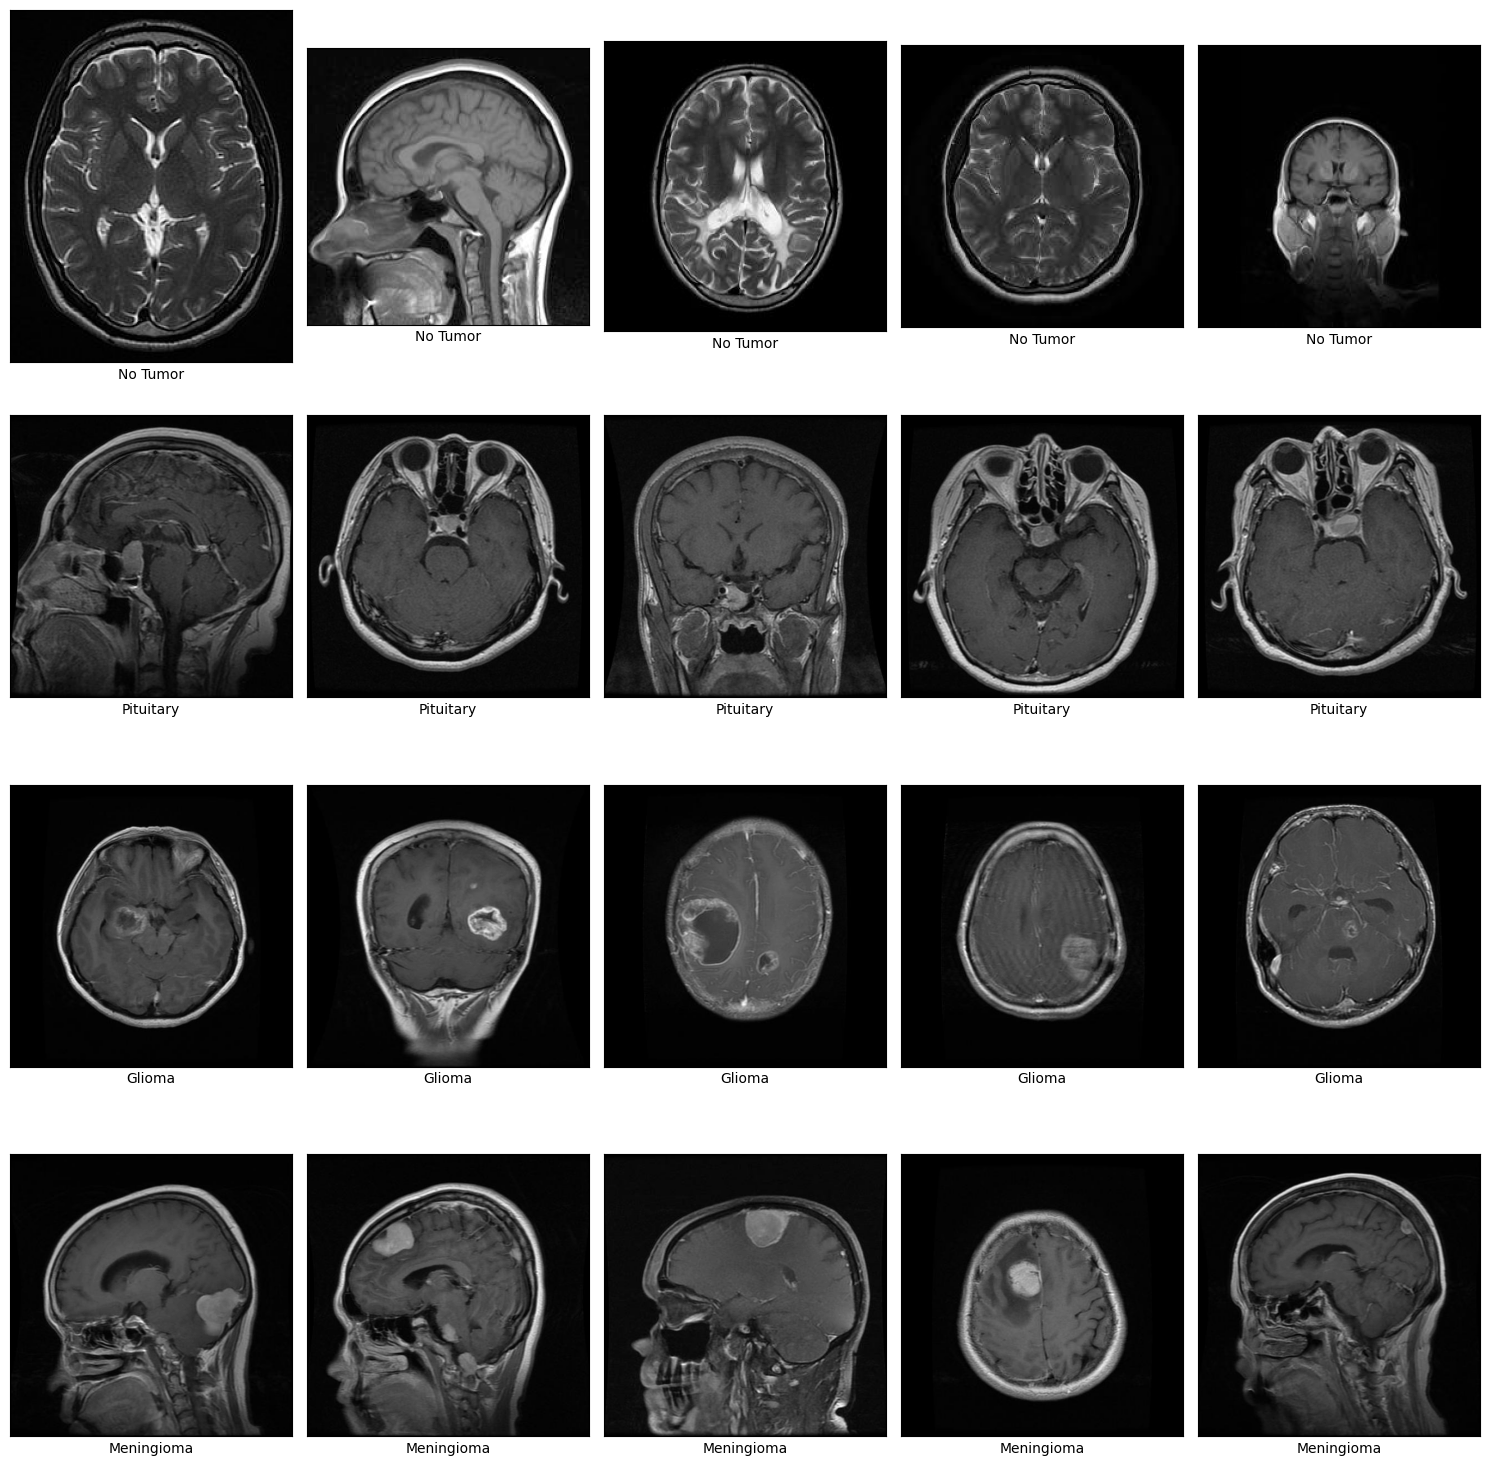

In [14]:
import matplotlib.pyplot as plt

lung_image = {}

path = os.path.join('', "dataset")
for i in os.listdir(path):
    lung_image[i] = os.listdir(os.path.join(path, i, "images"))
    print(lung_image)

path_sub = "dataset/"

fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, "images",image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

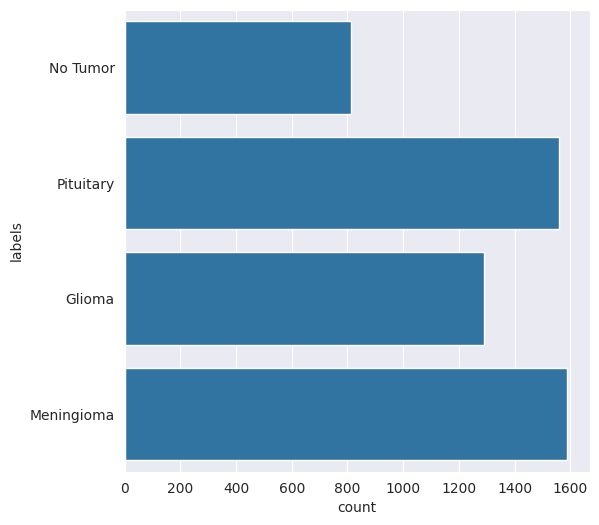

In [15]:
import seaborn as sns

lung_path = "dataset/"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(lung_path):
    if '/images' in path:
      for name in files:
          full_path.append(os.path.join(path, name))
          labels.append(path.split('/')[1])
          file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

## Data Augmentation

In [16]:
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

def flip_up_down(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return np.flipud(img)

def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [17]:
transformations = { 'rotate anticlockwise': anticlockwise_rotation,
                    'rotate clockwise': clockwise_rotation,
                    'warp shift': warp_shift,
                    'blurring image': blur_image,
                    'add brightness' : add_brightness,
                    'flip up down': flip_up_down,
                    'shear image': sheared
                  }

images_path="dataset/No Tumor/images"
augmented_path="dataset/No Tumor/images"
images=[]

for im in os.listdir(images_path):
    images.append(os.path.join(images_path,im))

images_to_generate=800
i=1

while i<=images_to_generate:
    image=random.choice(images)
    try:
        original_image = io.imread(image)
        transformed_image=None
        n = 0
        transformation_count = random.randint(1, len(transformations))

        while n <= transformation_count:
            key = random.choice(list(transformations))
            transformed_image = transformations[key](original_image)
            n = n + 1

        new_image_path= "%s/augmented_image_%s.jpg" %(augmented_path, i)
        transformed_image = img_as_ubyte(transformed_image)
        cv2.imwrite(new_image_path, transformed_image)
        i =i+1
    except ValueError as e:
        print('could not read the',image ,':',e,'hence skipping it.')

dataset/No Tumor/images [] ['image(95).jpg', 'augmented_image_72.jpg', 'Tr-no_0013.jpg', 'augmented_image_37.jpg', 'image(317).jpg', 'Tr-no_0071.jpg', 'augmented_image_493.jpg', 'augmented_image_111.jpg', 'augmented_image_640.jpg', 'image(172).jpg', 'Tr-no_1165.jpg', 'image(49).jpg', 'Tr-no_1475.jpg', 'Tr-no_0011.jpg', 'augmented_image_710.jpg', 'Tr-no_1531.jpg', 'Tr-no_1113.jpg', 'image(192).jpg', 'augmented_image_272.jpg', 'augmented_image_411.jpg', 'augmented_image_368.jpg', 'image(45).jpg', 'augmented_image_328.jpg', 'augmented_image_26.jpg', 'augmented_image_363.jpg', 'Tr-no_1067.jpg', 'Tr-no_1248.jpg', 'augmented_image_788.jpg', 'augmented_image_243.jpg', 'augmented_image_521.jpg', 'image (45).jpg', 'Tr-no_0753.jpg', 'augmented_image_104.jpg', 'augmented_image_261.jpg', 'Tr-no_0600.jpg', 'augmented_image_98.jpg', 'augmented_image_360.jpg', 'augmented_image_792.jpg', 'augmented_image_68.jpg', 'augmented_image_513.jpg', 'Tr-no_0438.jpg', 'Tr-no_1031.jpg', 'Tr-no_1213.jpg', 'image(1

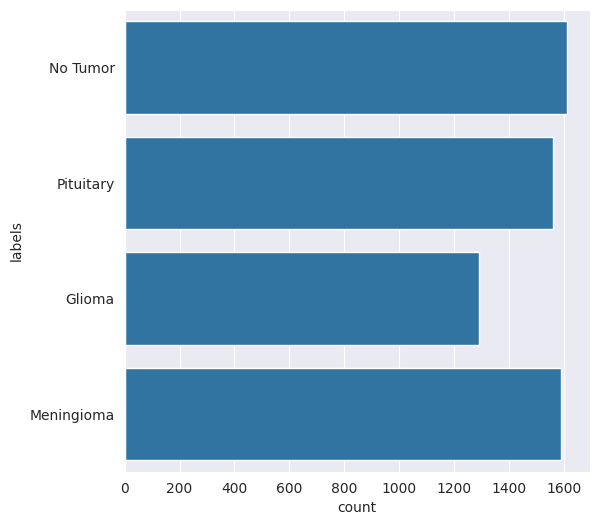

In [18]:
import seaborn as sns


lung_path = "dataset/"


file_name = []
labels = []
full_path = []


for path, subdirs, files in os.walk(lung_path):
    if '/images' in path:
      print(path, subdirs, files)
      for name in files:
          full_path.append(os.path.join(path, name))
          labels.append(path.split('/')[1])
          file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})


Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [19]:
mypath= 'dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    if '/images' in path:
      for name in files:
          full_path.append(os.path.join(path, name))
          labels.append(path.split('/')[1])
          file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
df.groupby(['labels']).size()

,0
labels,
Glioma,1289
Meningioma,1589
No Tumor,1611
Pituitary,1560


## Split Data

In [20]:
X= df['path']
y= df['labels']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [21]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [22]:
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

print(df_all.sample(5))

datasource_path = "dataset/"
dataset_path = "Dataset-Final/"


set    labels    
test   Glioma         265
       Meningioma     314
       No Tumor       324
       Pituitary      307
train  Glioma        1024
       Meningioma    1275
       No Tumor      1287
       Pituitary     1253
dtype: int64 


                                          path      labels    set
2683  dataset/Meningioma/images/Tr-me_0902.jpg  Meningioma  train
1051    dataset/No Tumor/images/Tr-no_0843.jpg    No Tumor  train
4599      dataset/Pituitary/images/p (407).jpg   Pituitary  train
2525      dataset/Pituitary/images/p (208).jpg   Pituitary  train
2926  dataset/Meningioma/images/Tr-me_0020.jpg  Meningioma  train


In [23]:
for index, row in tq(df_all.iterrows()):
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

In [24]:

TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_notumor = os.path.join(TRAIN_DIR + '/No Tumor')
train_glioma = os.path.join(TRAIN_DIR + '/Glioma')
train_meningioma = os.path.join(TRAIN_DIR + '/Meningioma')
train_pituitary = os.path.join(TRAIN_DIR + '/Pituitary')
test_notumor = os.path.join(TEST_DIR + '/No Tumor')
test_glioma = os.path.join(TEST_DIR + '/Glioma')
test_meningioma = os.path.join(TEST_DIR + '/Meningioma')
test_pituitary = os.path.join(TEST_DIR + '/Pituitary')

print("Total number of normal images in training set: ",len(os.listdir(train_notumor)))
print("Total number of glioma images in training set: ",len(os.listdir(train_glioma)))
print("Total number of meningioma images in training set: ",len(os.listdir(train_meningioma)))
print("Total number of pituitary images in training set: ",len(os.listdir(train_pituitary)))
print("Total number of normal images in test set: ",len(os.listdir(test_notumor)))
print("Total number of glioma images in test set: ",len(os.listdir(test_glioma)))
print("Total number of meningioma images in test set: ",len(os.listdir(test_meningioma)))
print("Total number of pituitary images in test set: ",len(os.listdir(test_pituitary)))

Total number of normal images in training set:  1287
Total number of glioma images in training set:  1024
Total number of meningioma images in training set:  1275
Total number of pituitary images in training set:  1253
Total number of normal images in test set:  324
Total number of glioma images in test set:  265
Total number of meningioma images in test set:  314
Total number of pituitary images in test set:  307


In [25]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="grayscale",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                color_mode="grayscale",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(150,150),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 3873 images belonging to 4 classes.
Found 966 images belonging to 4 classes.
Found 1210 images belonging to 4 classes.


## Training Model

In [26]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150,150,1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))


model_1.add(Conv2D(32, (4, 4),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

model_1.add(Conv2D(32, (7, 7), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))


model_1.add(Flatten())
model_1.add(Dense(128, activation = 'relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation = 'relu'))
model_1.add(Dropout(0.3))

model_1.add(Dense(4, activation='softmax'))

model_1.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

print(model_1.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 37, 37, 32)          │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,327,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,403,076 (5.35 MB)

 Trainable params: 1,402,884 (5.35 MB)

 Non-trainable params: 192 (768.00 B)

None


In [29]:
%time

# Fitting / training model
history_1 = model_1.fit(train_generator,
                        epochs=30,
                        batch_size=32,
                        validation_data=validation_generator)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 23s 120ms/step - accuracy: 0.4215 - loss: 2.9265 - val_accuracy: 0.2650 - val_loss: 3.7539
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 27s 65ms/step - accuracy: 0.5194 - loss: 1.2563 - val_accuracy: 0.2660 - val_loss: 6.2885
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6352 - loss: 1.0123 - val_accuracy: 0.3478 - val_loss: 1.7420
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.6941 - loss: 0.8379 - val_accuracy: 0.3271 - val_loss: 2.0446
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7068 - loss: 0.7909 - val_accuracy: 0.8261 - val_loss: 0.4840
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.7497 - loss: 0.6690 - val_accuracy: 0.8841 - val_loss: 0.3596
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.7681 - loss: 0.5840 - val_accuracy: 0.8489 - val_loss: 0.5121
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.8166 - loss: 0.5159 - val_accura

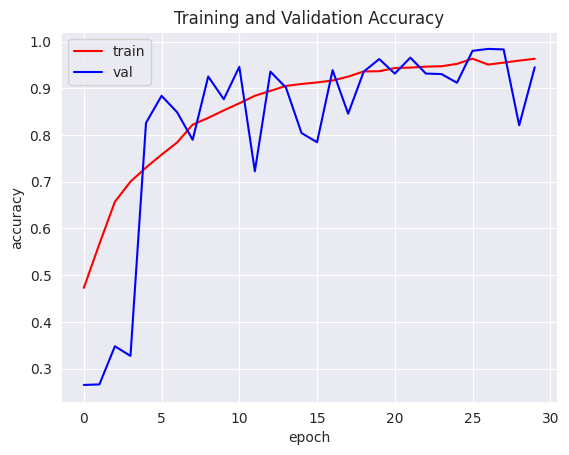

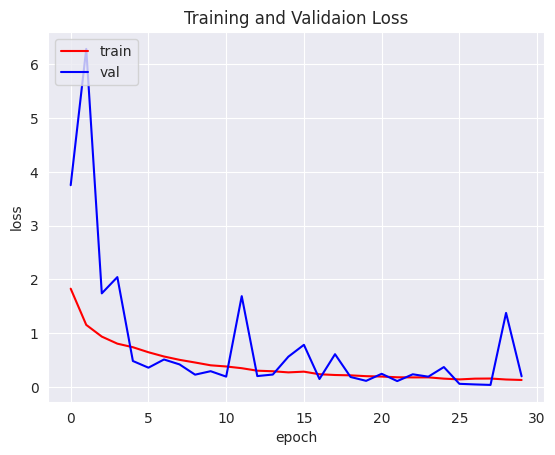

In [30]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

## Model Evaluation

In [31]:
class_indices = train_generator.class_indices

label_map = {v: k for k, v in class_indices.items()}

print("Mapping label ke kelas:")
for label, class_name in label_map.items():
    print(f"Label {label} adalah untuk kelas {class_name}")

Mapping label ke kelas:
Label 0 adalah untuk kelas Glioma
Label 1 adalah untuk kelas Meningioma
Label 2 adalah untuk kelas No Tumor
Label 3 adalah untuk kelas Pituitary


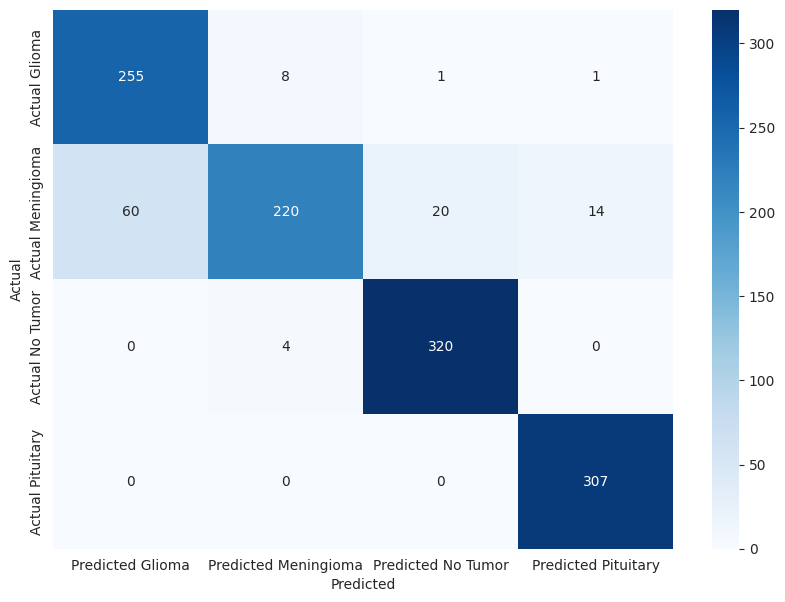



              precision    recall  f1-score   support

      Glioma     0.8095    0.9623    0.8793       265
  Meningioma     0.9483    0.7006    0.8059       314
    No Tumor     0.9384    0.9877    0.9624       324
   Pituitary     0.9534    1.0000    0.9762       307

    accuracy                         0.9107      1210
   macro avg     0.9124    0.9126    0.9059      1210
weighted avg     0.9166    0.9107    0.9071      1210



In [32]:
test_generator.reset()

preds_1 = model_1.predict(test_generator, verbose=0)

preds_1_classes = np.argmax(preds_1, axis=1)

class_names = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

cm = confusion_matrix(test_generator.classes, preds_1_classes, labels=[0, 1, 2, 3])
cm_df = pd.DataFrame(data=cm, index=[f"Actual {name}" for name in class_names], columns=[f"Predicted {name}" for name in class_names])

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt="d", cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n")
print(classification_report(test_generator.classes, preds_1_classes, target_names=class_names, digits=4))

## Save Model

In [33]:
model_1.save("model.h5")

In [1]:
!pip install tensorflowjs

!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2024-08-03 04:01:29.728846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 04:01:29.792393: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 04:01:29.792465: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 04:01:29.823882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 04:01:32.112222: W tensorflow/com

In [5]:
export_dir = 'saved_model/'
tf.saved_model.save(model_1, export_dir)


converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

5618356

In [4]:
!zip -r tfjs_model.zip tfjs_model


  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of2.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 89%)
  adding: tfjs_model/group1-shard1of2.bin (deflated 7%)


In [5]:
from google.colab import files
files.download('tfjs_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>